# Data modeling

In this notebook I prototype the two models used in AirbnBoost, (a) the __topic model__ and (b) the __pricing model__.

### Topic model

I am using a Latend Dirichlet Allocation (__LDA__) model to extract latent topics in Airbnb listing description. This way the user can easily select listings that match their taste. For instance, if the user is interested in searching for renovated listings with modern features, they can filter the topic __#modern__, which is extracted based on the topic model developed in this notebook.

### Pricing model

I am using __XGBoost__ to develop a pricing model, where I predict the price of each Airbnb listing in NYC using physical, urban, image, and topic modeling features. The pricing model aims to improve UX by adding a level of pricing transparency showing not only the actual listing price, but also its estimated price. This estimate reflects (assuming a robust and unbiased model) essentially __how similar listings are priced__. 

Moreover, based on the deviation between actual and estimated price the user can view underpriced listings, marked as __great deals__.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import clear_output
import pickle
import shap
import matplotlib.pylab as plt

import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('punkt')
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%pylab inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sokratis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sokratis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


In [2]:
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
 
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
# plt.rcParams['font.serif'] = 'Arial'
# plt.rcParams['font.family'] = "sans-serif"
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

## Data preprocessing
1. Clean misreported data and bring to machine readable format (e.g. price: $150,0 to 150.0)
2. Filter outliers in price using a logarithmic transformation and filtering out values that fall outside 2 standard deviations from the sample mean.
3. Convert categorical features to dummy variables.
4. Engineer new features (e.g. available the entire year, wifi provided, etc.)

In [3]:
df = pd.read_csv(r'../data/airbnb-fullUrbanFeats_img.csv', low_memory=False)
df.reset_index(inplace=True)
df.drop(['index','Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'], axis=1, inplace=True)
df = df[df.is_location_exact=='t']

In [4]:
df.closeSubway = df.closeSubway.apply(lambda x: 1 if x>0 else 0)
df.closeGrocery = df.closeGrocery.apply(lambda x: 1 if x>0 else 0)

Convert price to numeric and remove outliers.
Filter out listings that their price is higher or lower than 2$\sigma$ from the sample mean.

In [5]:
df['price'] = df.price.apply(lambda x: x.replace('$', ''))
df['price'] = df.price.apply(lambda x: float(x.replace(',', '')))
df['extra_people'] = df.extra_people.apply(lambda x: float(x.replace('$', '')))
df['invalid_neigh'] = df.neighbourhood_cleansed.apply(lambda x: 1 if '$' in x else 0)
df = df[df.invalid_neigh==0]


def flag_outliers(x, series):
    """ 
    Flags airbnb listings that log(price) is more than 2 std from the sample mean.
  
    Parameters: 
    x: individual listing price
    series: series with all listings in the data
  
    Returns: 
    r: decimal code for red color
    g: decimal code for green color
    b: decimal code for blue color
    bright: image brightness
  
    """    
    series = series.replace(0, 0.01)
    # logarithmic transformation to normalize the data
    log = np.log(series)
    upper = np.mean(log) + np.std(log)*2
    lower = np.mean(log) - np.std(log)*2
    
    if np.log(x)<lower or np.log(x)>upper:
        return 1
    else:
        return 0
    
df['flag_price'] = df['price'].apply((lambda x: flag_outliers(x, df['price'])))
df = df[df.flag_price==0]

Remove examples where there is no reviews (might be only temporary or fake listings that can skew the algorithm fit).

In [6]:
# remove listings without review rating
df.dropna(subset=['review_scores_rating'], inplace=True)

In [7]:
# Data preprocessing and additional feature engineering
df['response_rate_100'] = df.host_response_rate.apply(lambda x: 1 if x=='100%' else 0)
df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(lambda x: 1 if x=='t' else 0)
df['host_identity_verified'] = df['host_has_profile_pic'].apply(lambda x: 1 if x=='t' else 0)
df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 1 if x=='t' else 0)
df['wifi'] = df['amenities'].apply(lambda x: 1 if 'Wifi' in x else 0)
df['TV'] = df['amenities'].apply(lambda x: 1 if 'TV' in x else 0)
df['noSecurityDeposit'] = df.security_deposit.apply(lambda x: 1 if x=='$0.00' else 0)
df['noCostExtraPeople'] = df.extra_people.apply(lambda x: 1 if x==0 else 0)
df['availFullYear'] = df.availability_365.apply(lambda x: 1 if x==365 else 0)

propTypes = ['Apartment', 'Bed and breakfast', 'Boutique hotel', 'Condominium', 'Guest suite', 'Guesthouse', 'Hostel',
'Hotel', 'House', 'Loft', 'Resort', 'Serviced apartment', 'Townhouse']

df['property_type'] = df['property_type'].apply(lambda x: x if x in propTypes else 'Other')

In [8]:
# get dummy variables
host_response = pd.get_dummies(df.host_response_time, prefix='respTime')
neighbor = pd.get_dummies(df.neighbourhood_cleansed, prefix='loc')
propType = pd.get_dummies(df.property_type, prefix='propType')
roomType = pd.get_dummies(df.room_type, prefix='roomType')
bedType = pd.get_dummies(df.bed_type, prefix='bedType')
cancelPol = pd.get_dummies(df.cancellation_policy, prefix='cancel')
boro = pd.get_dummies(df.neighbourhood_group_cleansed, prefix='boro')

tmp = pd.concat([df, host_response], axis=1)
tmp = pd.concat([tmp, neighbor], axis=1)
tmp = pd.concat([tmp, propType], axis=1)
tmp = pd.concat([tmp, roomType], axis=1)
tmp = pd.concat([tmp, bedType], axis=1)
tmp = pd.concat([tmp, cancelPol], axis=1)
tmp = pd.concat([tmp, boro], axis=1)

Select features of interest to train the LDA and pricing model.

In [9]:
feats = ['host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60',
        'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication','review_scores_location',
        'review_scores_value', 'price', 'reviews_per_month', 'closeSubway', 'closeGrocery', 'closeNoise',
        'brightness', 'summary']

feats = feats + list(tmp.columns[104:])

data = tmp[feats]
data = data.dropna()
data.shape

(29358, 295)

## Topic modeling using LDA
Extract the latent topics included in the listing descriptions.
Pipeline:
1. Preprocess listing descriptions (tokenize, remove stopwords, lemmatize).
2. Create corpus using Bag of Words.
3. Find optimal number of topics using LDA coherence scores.
4. Use optimal LDA model to assign topics to listings.
5. Find the most "interpretable" topics.
6. Visualize topic clusters.
7. Assign listing to topic if $P(\textrm{description belonging to topic})>0.7$. The trheshold selection is arbitrary, but set high enough to minimize false positive rate.

In [10]:
text = data.summary

stop_words = gensim.parsing.preprocessing.STOPWORDS
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

# remove words that DO NOT characterize the listing itself
noise_words = ['apartment', 'building', 'bedroom', 'bedrooms', 'bathroom', 'kitchen', 'train', 'subway', 'central', 'brooklyn',
              'manhattan', 'williamsburg', 'street', 'city', 'place', 'space', 'guest', 'floor', 'state',
              'great', 'neighborhood', 'restaurant', 'restaurants', 'center', 'station', 'share', 'family', 'living', 'located',
              'location', 'block', 'blocks', 'square', 'walking', 'welcome', 'airbnb', 'minute', 'minutes', 'guests', 'guest', 'available']


def get_lemma(word):
    """ 
    Lemmatize a given word.
    
    Parameters: 
    word 

    Returns: 
    lemmatized version of word
  
    """      
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

    
def preprocessData(x):
    """ 
    Flags airbnb listings that log(price) is more than 2 std from the sample mean.
  
    Parameters: 
    x: individual listing price
    series: series with all listings in the data
  
    Returns: 
    r: decimal code for red color
    g: decimal code for green color
    b: decimal code for blue color
    bright: image brightness
  
    """  
    x = x.lower() # convert to lower case
    x = re.sub(r"\d+", "", x) #remove numbers
    regex = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation
    x = regex.sub("", x)
    x = x.strip() # remove whitespaces
    x = word_tokenize(x) #tokenize
    #stop_words = gensim.parsing.preprocessing.STOPWORDS
    x = [i for i in x if not i in stop_words] # remove stopwords
    x = [i for i in x if not i in noise_words]
            
    x = [get_lemma(i) for i in x]
    x = [lemmatizer.lemmatize(i) for i in x] # lematize words
    x = [i for i in x if len(i) > 4]
    #x = [stemmer.stem(i) for i in x] # stem words
    return x 

Text preprocessing.

In [11]:
text.replace(np.nan, '', inplace=True)

text_data = []

for i, line in enumerate(text):
    tokens = preprocessData(line)
    text_data.append(tokens)
    
    if i in np.arange(0,30000,1000):
        clear_output()
        print('Processed %s listings'%i)

Processed 29000 listings


In [12]:
bigram = gensim.models.Phrases(text_data, min_count=10, threshold=50)
text_data_bigrams = [bigram[line] for line in text_data]

Get corpus and dictionary.

In [13]:
dictionary = corpora.Dictionary(text_data_bigrams)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in text_data_bigrams]

Find optimal number of topics.

In [14]:
coherScores = {}

for numTopics in range(3,100):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = numTopics, id2word=dictionary, passes=1,  random_state=25)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=text_data_bigrams, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('NumTopis:', numTopics, '-- Coherence Score:', coherence_lda)
    
    coherScores[numTopics] = coherence_lda

# visualize coherence scores
plt.figure(figsize=(12,5))
plt.plot(coherScores.keys(), coherScores.values(), color="#328cc1")
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('LDA topic number selection')
plt.savefig(r'../output/lda_topicNumberSelection.png')
plt.show()

Train the optimal LDA model.

In [15]:
numTopics = 13
#ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=numTopics, id2word=dictionary, passes=10, random_state=25) 
#ldamodel.save('lda_model.gensim')
ldamodel = gensim.models.ldamodel.LdaModel.load('lda_model.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.043*"prospect" + 0.032*"historic" + 0.032*"beautiful" + 0.028*"brownstone"')
(1, '0.048*"heart" + 0.032*"distance" + 0.028*"village" + 0.026*"shopping"')
(2, '0.045*"sleep" + 0.037*"people" + 0.024*"queen" + 0.019*"perfect"')
(3, '0.035*"roommate" + 0.034*"friendly" + 0.028*"basement" + 0.024*"stainless_steel"')
(4, '0.047*"fully" + 0.037*"modern" + 0.032*"furnish" + 0.028*"feature"')
(5, '0.129*"private" + 0.091*"share" + 0.034*"single" + 0.026*"sunlight"')
(6, '0.113*"couple" + 0.081*"perfect" + 0.080*"traveler" + 0.045*"close"')
(7, '0.036*"close" + 0.031*"upper" + 0.029*"private" + 0.025*"airport"')
(8, '0.081*"private" + 0.033*"bushwick" + 0.029*"access" + 0.028*"backyard"')
(9, '0.057*"train" + 0.048*"harlem" + 0.038*"close" + 0.033*"express"')
(10, '0.045*"provide" + 0.042*"queen" + 0.035*"private" + 0.032*"include"')
(11, '0.049*"house" + 0.043*"close" + 0.043*"supermarket" + 0.035*"store"')
(12, '0.060*"large" + 0.055*"window" + 0.036*"ceiling" + 0.034*"light"')


Make word clouds.

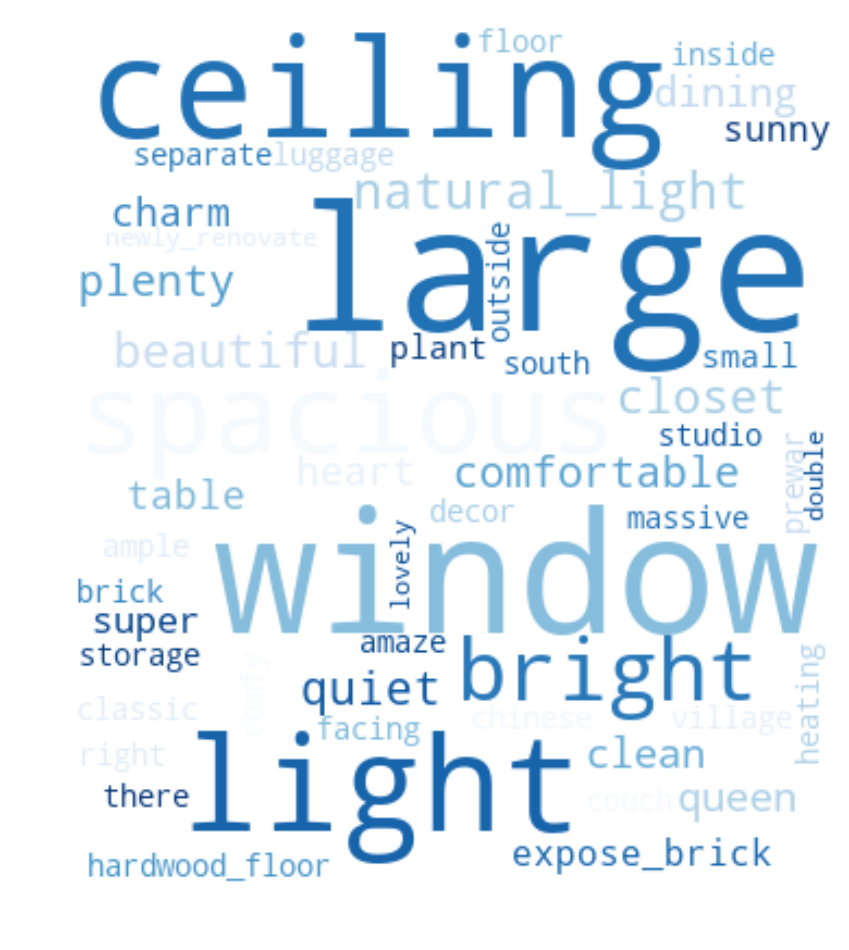

In [16]:
plt.imshow(WordCloud(width=350, height=400, max_font_size=80, max_words=50, collocations=True, colormap="Blues",
                         background_color="white", random_state=35).fit_words(dict(ldamodel.show_topic(12, 100))), interpolation="bilinear")
plt.axis("off")
plt.savefig(r'../output/wordcloud_Aesthetics.png')
plt.show()

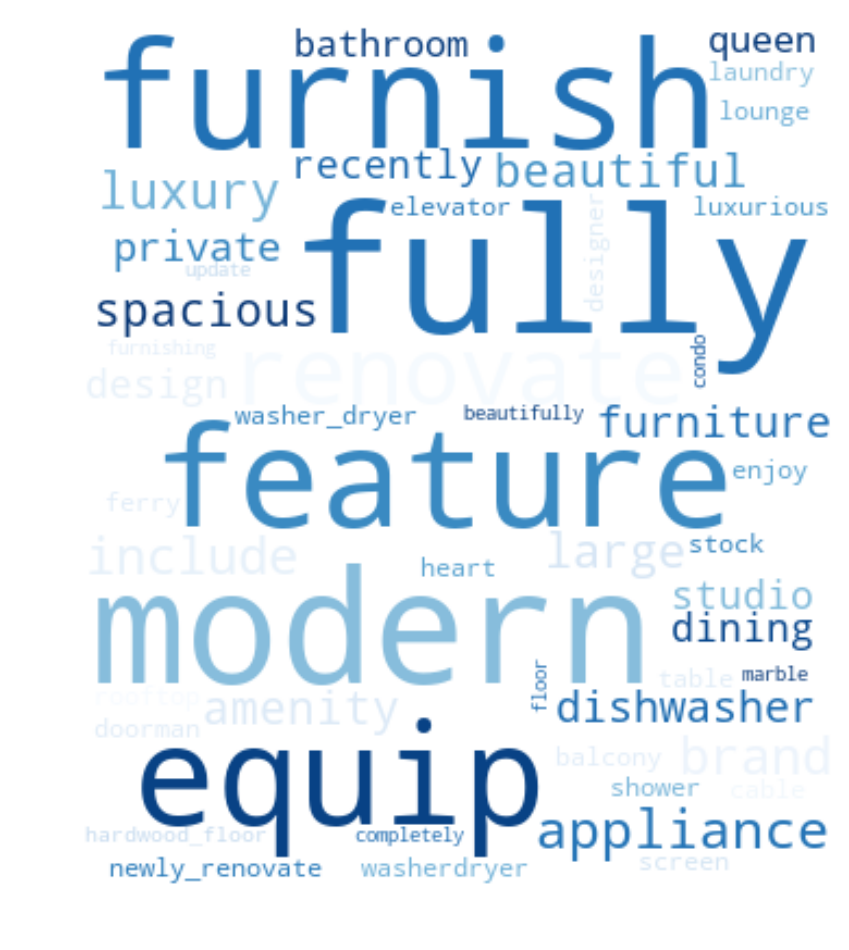

In [17]:
plt.imshow(WordCloud(width=350, height=400, max_font_size=80, max_words=50, collocations=True, colormap="Blues",
                         background_color="white", random_state=35).fit_words(dict(ldamodel.show_topic(4, 100))), interpolation="bilinear")
plt.axis("off")
plt.savefig(r'../output/wordcloud_Modern.png')
plt.show()

Visualize topics with pyLDAvis.

In [18]:
pyLDAvis.enable_notebook()
ldaVis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
ldaVis
# from IPython.display import HTML
# HTML(filename='topicModelingVis.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.112937  0.265413       1        1  11.329102
1      0.225819  0.044852       2        1  10.723179
8     -0.012842  0.053946       3        1   9.447364
12    -0.039598  0.172565       4        1   9.320891
0      0.191245  0.068421       5        1   8.988280
7      0.101506  0.072849       6        1   8.193501
2     -0.024728 -0.063192       7        1   7.319885
10    -0.276945  0.031130       8        1   7.112652
9      0.193687 -0.035895       9        1   6.929007
6      0.085985 -0.197022      10        1   6.276322
11     0.035475 -0.185946      11        1   5.287840
5     -0.225460 -0.146816      12        1   4.820088
3     -0.141207 -0.080306      13        1   4.251890, topic_info=     Category         Freq                   Term        Total  loglift  \
term                                                                      
30    Default  8489.000000                private  8489.000000  30.0000   
565   Default  2796.000000                 couple  2796.000000  29.0000   
7     Default  2404.000000                  share  2404.000000  28.0000   
177   Default  1987.000000               traveler  1987.000000  27.0000   
212   Default  3605.000000                perfect  3605.000000  26.0000   
21    Default  2175.000000                 window  2175.000000  25.0000   
79    Default  5907.000000                  close  5907.000000  24.0000   
137   Default  2178.000000                  fully  2178.000000  23.0000   
447   Default  2959.000000                  train  2959.000000  22.0000   
185   Default  2414.000000                  house  2414.000000  21.0000   
190   Default  1514.000000               prospect  1514.000000  20.0000   
486   Default  1320.000000                 harlem  1320.000000  19.0000   
74    Default  1305.000000                  sleep  1305.000000  18.0000   
457   Default  1450.000000                provide  1450.000000  17.0000   
117   Default  4434.000000                  large  4434.000000  16.0000   
26    Default  1804.000000                furnish  1804.000000  15.0000   
129   Default  3876.000000                  queen  3876.000000  14.0000   
436   Default  1251.000000               bushwick  1251.000000  13.0000   
782   Default  1037.000000                 family  1037.000000  12.0000   
166   Default  1634.000000                 closet  1634.000000  11.0000   
339   Default  1594.000000                ceiling  1594.000000  10.0000   
53    Default  1970.000000                 people  1970.000000   9.0000   
145   Default  3451.000000               distance  3451.000000   8.0000   
505   Default  1227.000000            supermarket  1227.000000   7.0000   
136   Default  1492.000000                  equip  1492.000000   6.0000   
316   Default  1329.000000                  store  1329.000000   5.0000   
15    Default  1366.000000               historic  1366.000000   4.0000   
820   Default   902.000000                 friend   902.000000   3.0000   
228   Default  1734.000000                village  1734.000000   2.0000   
200   Default  1045.000000               backyard  1045.000000   1.0000   
756    Topic1   241.529968                 marble   242.416840   2.1741   
874    Topic1   349.133545              luxurious   350.513824   2.1738   
1795   Topic1   175.643753          staten_island   176.530502   2.1728   
739    Topic1   166.484924                utensil   167.372162   2.1725   
1414   Topic1   140.250717           breathtaking   141.137466   2.1715   
1516   Topic1   134.242920              oversized   135.129639   2.1712   
500    Topic1   119.844589                spanish   120.731339   2.1704   
1508   Topic1   114.897865           architecture   115.784599   2.1701   
735    Topic1   230.917053                 update   232.731781   2.1700   
298    Topic1   106.541481                 custom   107.428566   2.1695 

In [19]:
# save visualization
pyLDAvis.save_html(ldaVis, 'topicModelingVis.html')

Assign topics to listings.

In [20]:
def assignTopic(new_doc):
    """ 
    Characterize listings based on their description
    
    Parameters: 
    new_doc: document including listing summary 

    Returns: 
    Topic characterization or None if topic is not assigned
  
    """ 
    new_doc = preprocessData(new_doc)
    new_doc_bow = dictionary.doc2bow(new_doc) # convert document to bag of words
    topic_ass = ldamodel.get_document_topics(new_doc_bow) # get topic likelihood for given document
    idx  = [i[0] for i in topic_ass if i[1]>0.7] # set threshold: P(belonging_to_topic)>0.7
    try:
        if idx[0] == 4:
            return 'modern'
        elif idx[0] == 12:
            return 'aesthetics'
    except:
        return None

In [21]:
data['hashtag'] = data.summary.apply(assignTopic)

In [22]:
# count assignments in each topic
data.groupby('hashtag')['hashtag'].count()

hashtag
aesthetics    111
modern        176
Name: hashtag, dtype: int64

In [23]:
data.groupby('hashtag')['price'].median()

hashtag
aesthetics    149.0
modern        150.0
Name: price, dtype: float64

In [24]:
print ('Median Airbnb listing price:', data.price.median())

Median Airbnb listing price: 105.0


Both listing characterized based on #aesthetics and #modern show significantly higher prices on average.

In [25]:
# get dummy variables from hashtags
hashDummies = pd.get_dummies(data.hashtag, prefix='hashtag')
data = pd.concat([data, hashDummies], axis=1)

## Pricing model
I use XGBoost to model the listing price (target) given a set of predictors (features). Besides the listing physical characteristics (e.g. number of bedrooms, number or guests, location, etc.), I am using the listing characterization computed above, location intelligence features, such as proximity to subway, neighborhood noise levels, and image-related features such as the brightness of the RGB channels of the listing's main image.

### XGBoost model selection
Splitting the dataset into train and validation set (80/20). Then, tuning two main XGBoost parameters; __learning rate__, the rate in which the gradient changes in each boosting iteration, and __max_depth__, which is the maximum depth each constituent is allowed to grow. 

Within the training set, run a 5-fold cross-validation and report the average RMSE. Finally, select the model with the lowest RMSE and evaluate its performance on unseen data (test set).

Note that I model the natural logarithm of price; this is for the target to follow a normal distribution and help my model learn easier patterns in the data.

In [26]:
# set features and target
X = data.drop(['price', 'hashtag', 'summary'], axis=1)
y = data.price

# split 80/20 train-validation set
Xt, Xv, yt, yv = train_test_split(X, np.log(y), test_size=0.2, random_state=14)
dtrain = xgb.DMatrix(Xt.as_matrix(), label=yt.as_matrix())
dtest = xgb.DMatrix(Xv.as_matrix(), label=yv.as_matrix())

Run 5-fold CV

In [27]:
# initialize params
params = {'max_depth':3,
    'learning_rate':.3}

min_rmse = float("Inf")
best_params = None


for learning_rate in [.2, .1, .05]:
    for max_depth in range(3,7):
        clear_output()
        print("CV with learning_rate={}".format(learning_rate))
        print("CV with max_depth={}".format(max_depth))

        # update parameters
        params['learning_rate'] = learning_rate
        params['max_depth'] = max_depth

        # run and time CV
        %time cv_results = xgb.cv(params,dtrain,num_boost_round=1000,seed=25,nfold=5, metrics=['rmse'], early_stopping_rounds=20)

        # update best score
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].idxmin()
        print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse

            best_params = {'learning_rate': learning_rate, 'max_depth':max_depth}
            best_trees = boost_rounds

print('=='*60)
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

# pickle optimal hyperparameters
best_params['random_state'] = 25
best_params['n_estimators'] = best_trees
pickle.dump(best_params, open('xgboost_params.pkl', 'wb'))

### XGBoost model
Having the optimal parameters obtained I fit the model and evaluate its report its performance on test data. Following, I train the model on the entire dataset (since I care to have a price estimate for each Airbnb listing in NYC).

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """ 
    Calculates mean absolute percentage error.
    
    Parameters: 
    y_true: series/array of observed values
    y_pred: series/array of predicted values

    Returns: 
    mean absolute percentage error
  
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
print ("The optimal XGBoost parameters are:")
opt_params = pickle.load(open('xgboost_params.pkl', 'rb'))
opt_params

The optimal XGBoost parameters are:


{'learning_rate': 0.2, 'max_depth': 3, 'random_state': 25, 'n_estimators': 796}

In [30]:
mdl = xgb.XGBRegressor(**opt_params)
mdl.fit(Xt, yt)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=796,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=25,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
print ("Training R2:", mdl.score(Xt, yt))
print ("Testing R2:", mdl.score(Xv, yv))
print ('')
print ("Training RMSE:", sqrt(mean_squared_error(yt, mdl.predict(Xt))))
print ("Testing RMSE:", sqrt(mean_squared_error(yv, mdl.predict(Xv))))
print ('')
print ("Training MAE:", median_absolute_error(yt, mdl.predict(Xt)))
print ("Testing MAE:", median_absolute_error(yv, mdl.predict(Xv)))

Training R2: 0.8267301551550886
Testing R2: 0.7688975855568014

Training RMSE: 0.24574724396890074
Testing RMSE: 0.2824676791931484

Training MAE: 0.14746907255108388
Testing MAE: 0.1744739092062324


Fit model on full dataset

In [32]:
mdlFinal = xgb.XGBRegressor(**opt_params)
mdlFinal.fit(X, np.log(y))

print ("XGBoost model R2:", mdlFinal.score(X,np.log(y)))
print ("XGBoost model MAE:", median_absolute_error(y, np.exp(mdlFinal.predict(X))))

XGBoost model R2: 0.8179602265326934
XGBoost model MAE: 15.454717636108398


### Model interpretation and diagnostics
- Run diagnostics on the model error term and explore potential biases.
- Interpret the model using SHAP.

Plot error diagnostics.

In [33]:
# set price estimates
data['priceEstimate'] = np.exp(mdlFinal.predict(X))

# error term
yPred = np.exp(mdlFinal.predict(X))
yPred_log = mdlFinal.predict(X)
err = y - yPred
errLog = np.log(y) - yPred_log

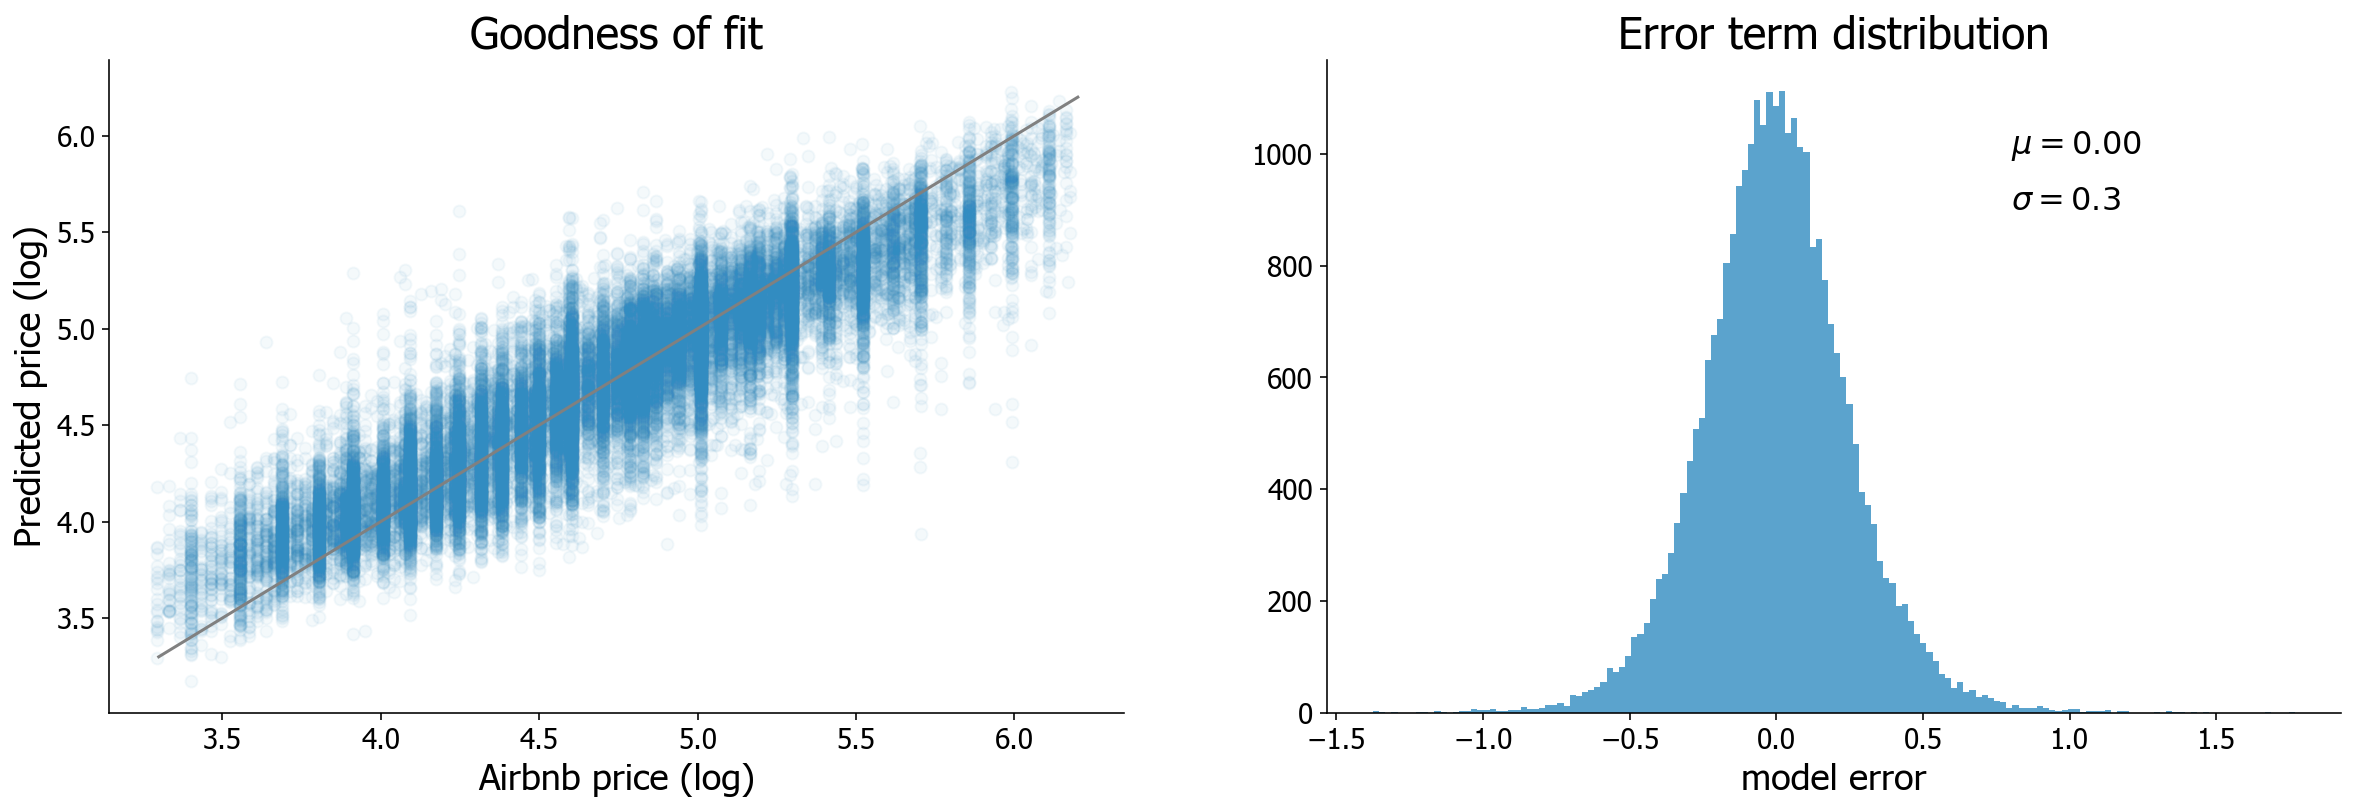

In [34]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.scatter(np.log(y), yPred_log, color="#328cc1", alpha=.05)
plt.xlabel('Airbnb price (log)')
plt.ylabel('Predicted price (log)')
plt.plot([3.3, 6.2], [3.3, 6.2], lw=1.5, color='gray')
plt.title('Goodness of fit')
plt.subplot(122)
plt.hist(errLog, bins=150, color="#328cc1", alpha=.8)
plt.xlabel('model error')
plt.title('Error term distribution')
plt.text(0.8, 1000, '$\mu = %.2f$'%errLog.mean(), size=16)
plt.text(0.8, 900, '$\sigma = %.1f$'%errLog.std(), size=16)
plt.savefig(r'../output/model_error.png')
plt.show()

In the plot above we see the model goodness of fit (left) and distribution of residuals (right). The gray line represents the 1-1 line. 
The error term is normally distributed with $\mu=0$ and $\sigma=0.3$, showing that there is no information left in the residual.

--------
Feature importance using SHAP

XGBoost is famous for its high accuracy, however this comes with limited interpretability compared to linear models. Classic feature importance methods, although useful, lack information regarding the direction of the relationship between features and target. To address that, I am using SHAP (SHapley Additive exPlanations), an unbiased and interpretable feature attribution method.

For more info on implementation see: _Lundberg, S.M. and Lee, S.I., 2017. "A unified approach to interpreting model predictions." In Advances in Neural Information Processing Systems (pp. 4765-4774)._

In [35]:
# obtain shap values
shap_values = shap.TreeExplainer(mdlFinal).shap_values(X)

In [36]:
shap_imp = pd.DataFrame({'feat': X.columns, 'imp':np.abs(shap_values).mean(0)})
shap_imp = shap_imp.sort_values('imp', ascending=False)
shap_imp

,feat,imp
274,roomType_Entire home/apt,0.291662
290,boro_Manhattan,0.184677
4,accommodates,0.081442
8,guests_included,0.044714
6,bedrooms,0.039176
9,minimum_nights,0.038177
23,reviews_per_month,0.034827
16,review_scores_rating,0.031986
37,noCostExtraPeople,0.031704
254,loc_Williamsburg,0.031479


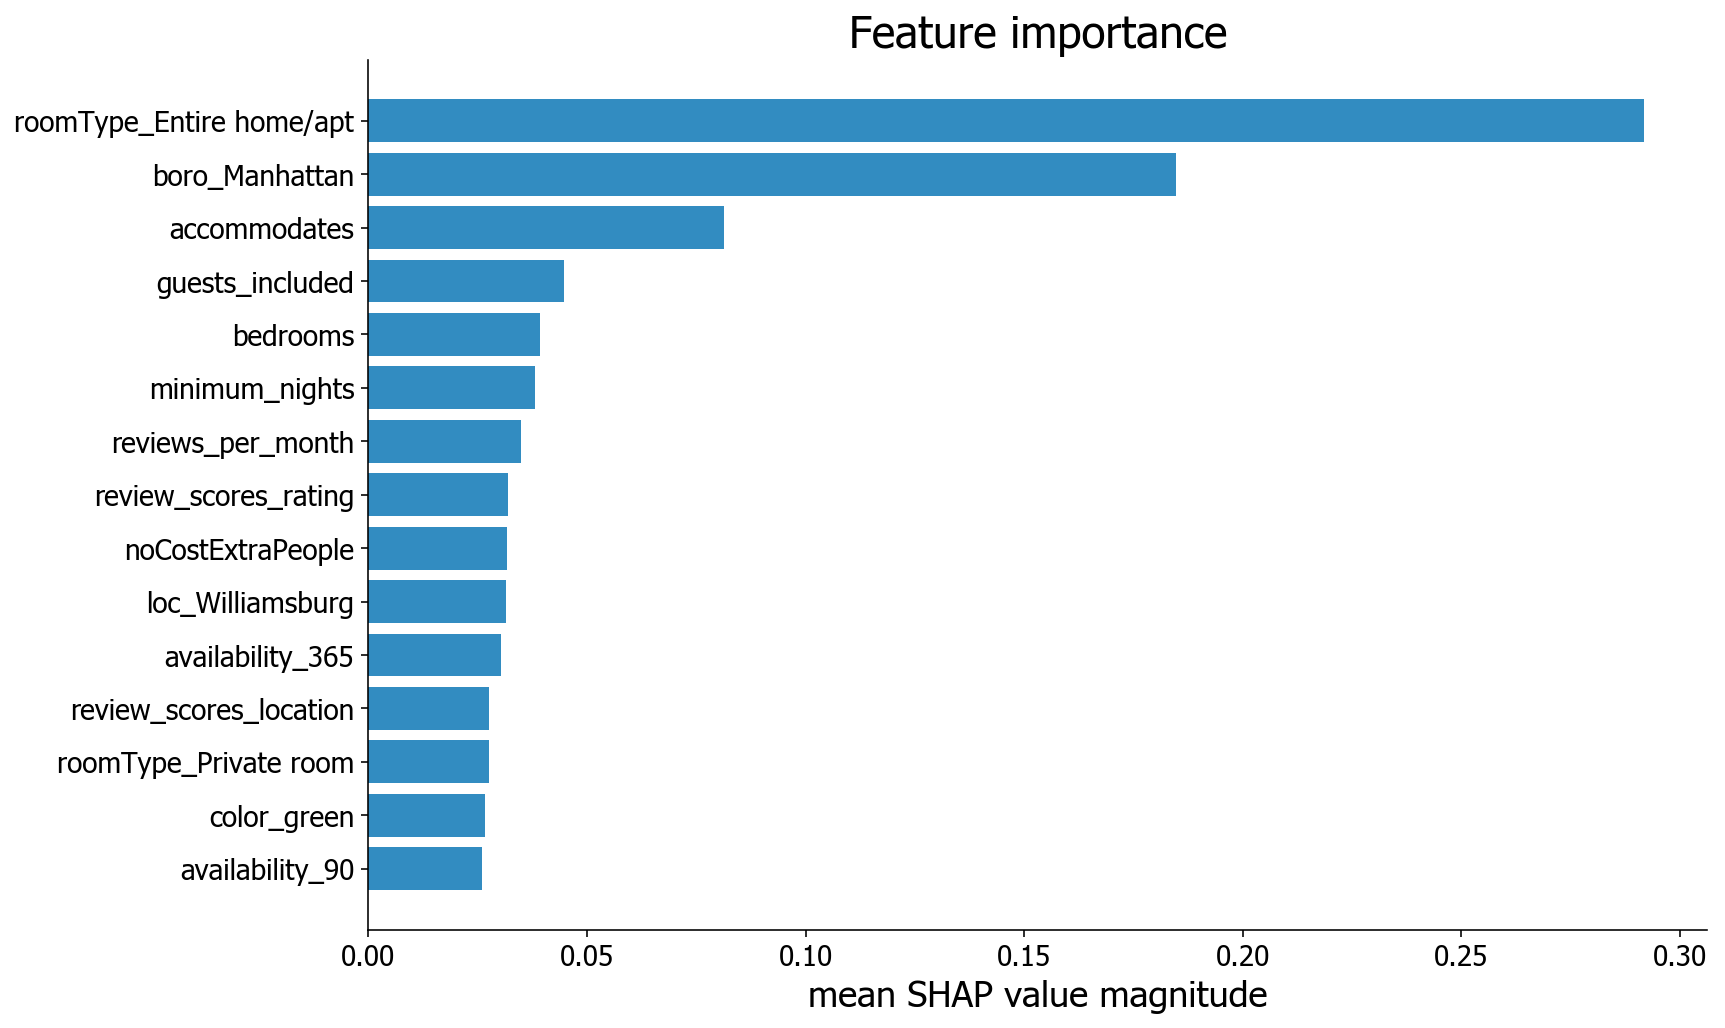

In [37]:
show_top = 15
global_shap_vals = np.abs(shap_values).mean(0)
inds = np.argsort(global_shap_vals)
y_pos = np.arange(X.shape[1])
plt.barh(range(show_top), shap_imp.imp.iloc[:show_top], color="#328cc1")
plt.yticks(range(show_top), shap_imp.feat.iloc[:show_top])
plt.xlabel("mean SHAP value magnitude")
plt.gca().invert_yaxis()
plt.title('Feature importance')
plt.savefig(r'../output/shap_featImp.png', bbox_inches = "tight")
plt.show()

Classic feature importance using SHAP.

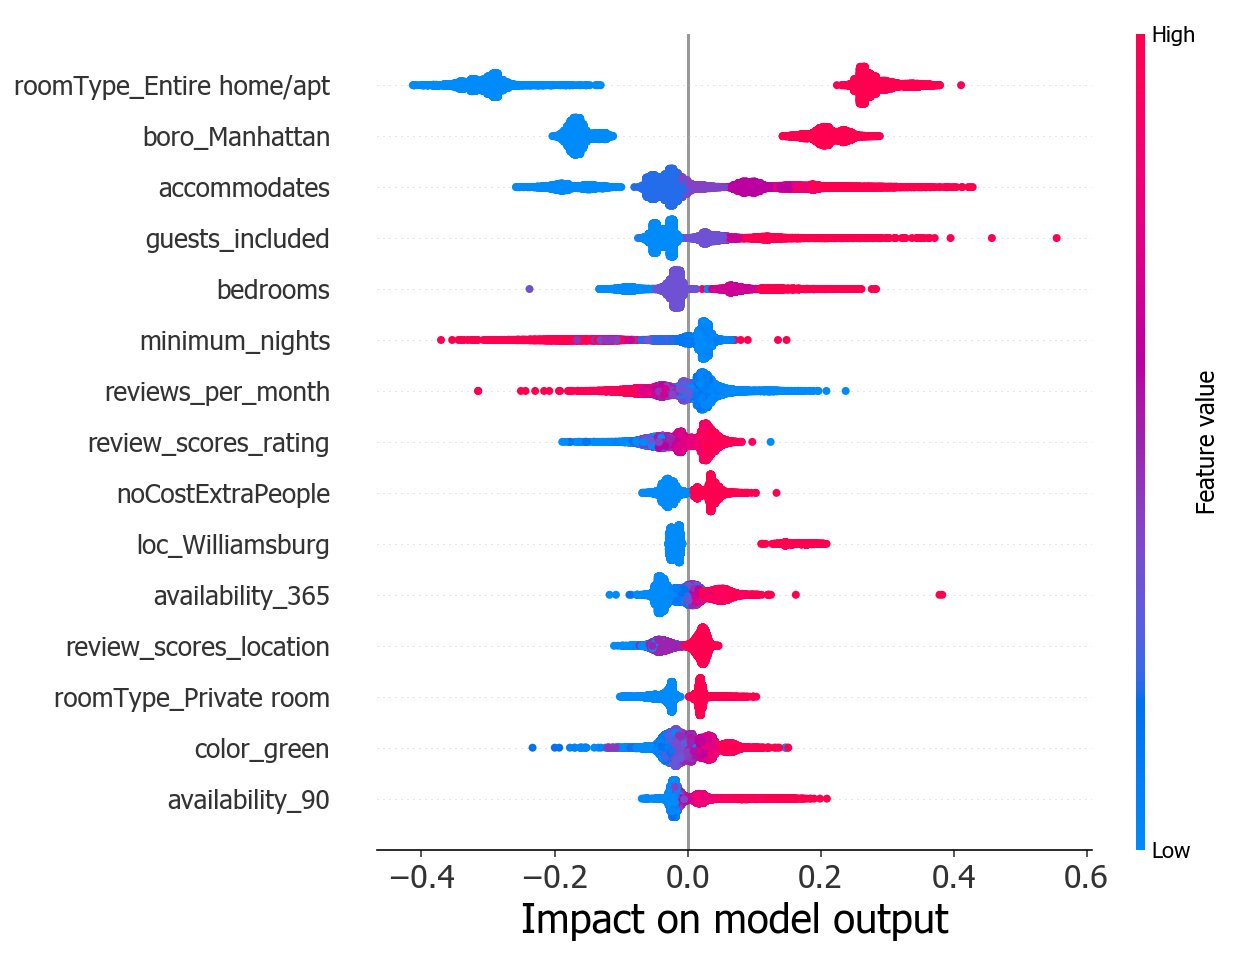

In [38]:
plt.figure(figsize=(9,6))
shap.summary_plot(shap_values, X, title='SHAP values', max_display=15, auto_size_plot=True, show=False)
plt.xticks(size=16)
plt.xlabel('Impact on model output',size=20)
#plt.savefig(r'../output/shap_tree.png', bbox_inches = "tight")
plt.show()

SHAP summary plot. 

On the __y-axis__ we see features ranked based on importance (similar to the previous figure).

The __color-coding__ represents feature values.

On the __x-axis__ we show the feature value's impact on price (target).

For instance, if the listing is an entire home or located in Manhattan (red values), has a positive impact on price. On the other hand, listing with higher minimum nights of stay tend to be priced lower, which is a reasonable finding. Interestingly enough, we see that the brightness of __color_green__ has a positive impact on the price. This validates my original hypothesis that brighter images predespose user to pay more for a listing (or in other words if a host is offering a high-quality product is most likely to take professional pictures of their listing). 

### Output results
Save model outputs and relevant features for the front-end.

In [39]:
dfOut = df[['listing_url', 'name', 'picture_url', 'latitude', 'longitude']]

output = data[['accommodates', 'guests_included', 'bathrooms', 'bedrooms', 'beds', 'price', 'priceEstimate',
                 'closeSubway', 'closeGrocery', 'closeNoise', 'hashtag']]

out = pd.merge(dfOut, output, left_index=True, right_index=True)
out['price'] = out['price'].apply(lambda x: round(x))
out['priceEstimate'] = out['priceEstimate'].apply(lambda x: round(x))

Add some features for better UX.

In [40]:
out['error'] = errLog

def greatDeals(x, series):
    """ 
    Find great deals based on the error of the model prediction
    
    Parameters: 
    x: individual error term
    series: series of error terms

    Returns: 
    TRUE is error is more than 3x std lower than mean (i.e. underpriced listings)
  
    """ 
    lower = np.mean(series) - np.std(series)*3
    if x<lower:
        return 'TRUE'
    else:
        return None
    
# flag great deals
out['greatDeal'] = out['error'].apply((lambda x: greatDeals(x, out['error'])))

# bin noise complaints in 3 quantiles for better UX
out['noiseLevel'] = pd.qcut(out.closeNoise, 3, labels=["low", "moderate", "high"])

# get booleans for proximity to subway and grocery stores
out['closeSubwayBool'] = out.closeSubway.apply(lambda x: 'TRUE' if x==1 else None)
out['closeGroceryBool'] = out.closeGrocery.apply(lambda x: 'TRUE' if x==1 else None)

In [41]:
# output end results and save to csv
final = out
final.drop(['error', 'closeSubway', 'closeGrocery'], axis=1, inplace=True)
final.to_csv(r'../output/dataForFrontEnd.csv', index=False)

## Appendix

### Pricing model - Additional validation

In this Section I check for potential spatial bias in the pricing model's predictions.

In [42]:
dfMerg = pd.merge(df[['neighbourhood_cleansed','neighbourhood_group_cleansed', 'zipcode', 'Coordinates']], final, left_index=True, right_index=True)
dfMerg['log_error'] = np.log(dfMerg.price) - np.log(dfMerg.priceEstimate)
dfMerg['error'] = dfMerg.price - dfMerg.priceEstimate
dfMerg.groupby('neighbourhood_group_cleansed').median()

,latitude,longitude,accommodates,guests_included,bathrooms,bedrooms,beds,price,priceEstimate,closeNoise,log_error,error
neighbourhood_group_cleansed,,,,,,,,,,,,
Bronx,40.847210,-73.897003,2.0,1.0,1.0,1.0,1.0,65.0,63.0,106.0,-0.004975,-0.5
Brooklyn,40.687460,-73.952332,2.0,1.0,1.0,1.0,1.0,95.0,95.0,134.0,0.000000,0.0
Manhattan,40.761519,-73.979995,2.0,1.0,1.0,1.0,1.0,140.0,142.0,295.0,0.000000,0.0
Queens,40.746085,-73.900943,2.0,1.0,1.0,1.0,1.0,75.0,73.0,56.0,-0.013245,-1.0
Staten Island,40.627426,-74.086449,3.0,1.0,1.0,1.0,2.0,70.0,70.0,12.0,0.000000,0.0


I aggregate the model errors in Borough level. The median error per Borough is either 0 or -1$, showing no bias here.

Moving on, I aggreage the errors in neighborhood level.

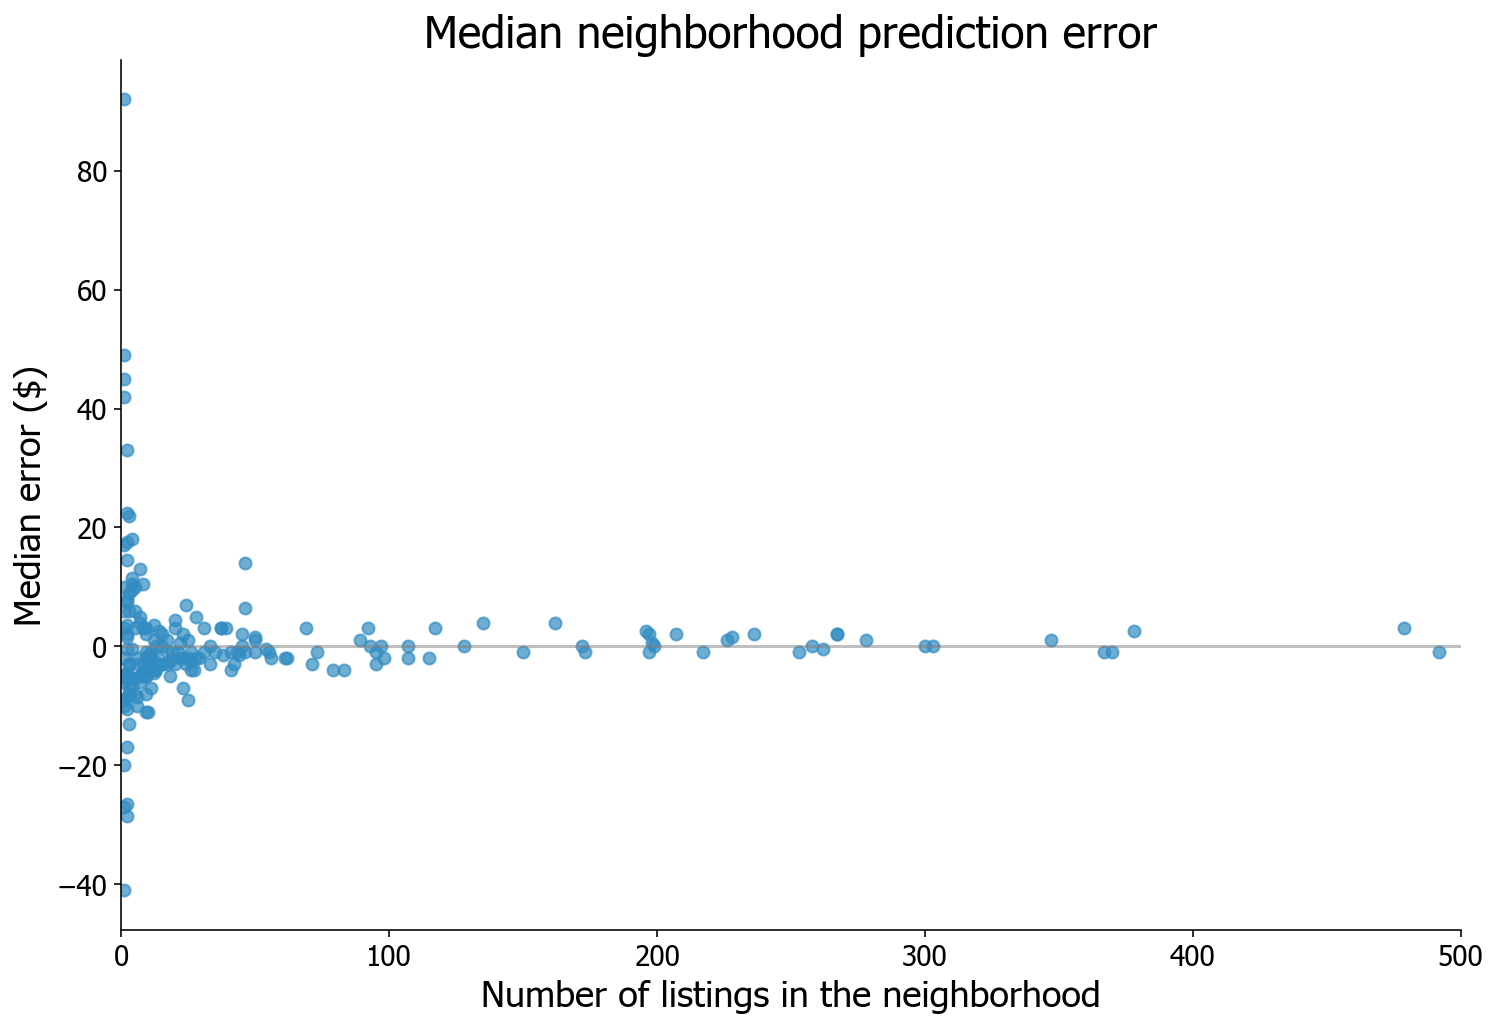

In [43]:
plt.scatter(dfMerg.groupby('neighbourhood_cleansed').count()['error'], 
            dfMerg.groupby('neighbourhood_cleansed').median()['error'], color="#328cc1", alpha=.7)
plt.xlim(0,500)
plt.axhline(y=0, color='gray', alpha=.5)
plt.title('Median neighborhood prediction error')
plt.xlabel('Number of listings in the neighborhood')
plt.ylabel('Median error ($)')
plt.savefig(r'../output/spatial_dist_error.png', bbox_inches="tight")
plt.show()

In the plot above we see the main source of error in the model. Neighborhoods with very low number of listings ($<20$) tend to exhibit larger median errors, up to 60$.

Based on that, I conclude that in the neigborhoods with low number of listings the algorithm is not able to capture the pricing dynamics resulting into higher errors. This can be alleviated as Airbnb intrudes more and more in the market, increasing its listings, as we can see from neighborhoods with more than 100 listings.

In [44]:
# load nyc zipcodes shapefile
zipCodes = gpd.read_file("../data/ZIP_CODE_040114/ZIP_CODE_040114.shp")

zipErr = pd.DataFrame()
zipErr['medianErr'] = dfMerg.groupby('zipcode').median()['error']

zips = pd.merge(zipErr, zipCodes, left_index=True, right_on='ZIPCODE')
zips = gpd.GeoDataFrame(zips)

# bin zipCode level errors
zips_more10 = zips[abs(zips.medianErr)>10]
zips_more20 = zips[abs(zips.medianErr)>20]

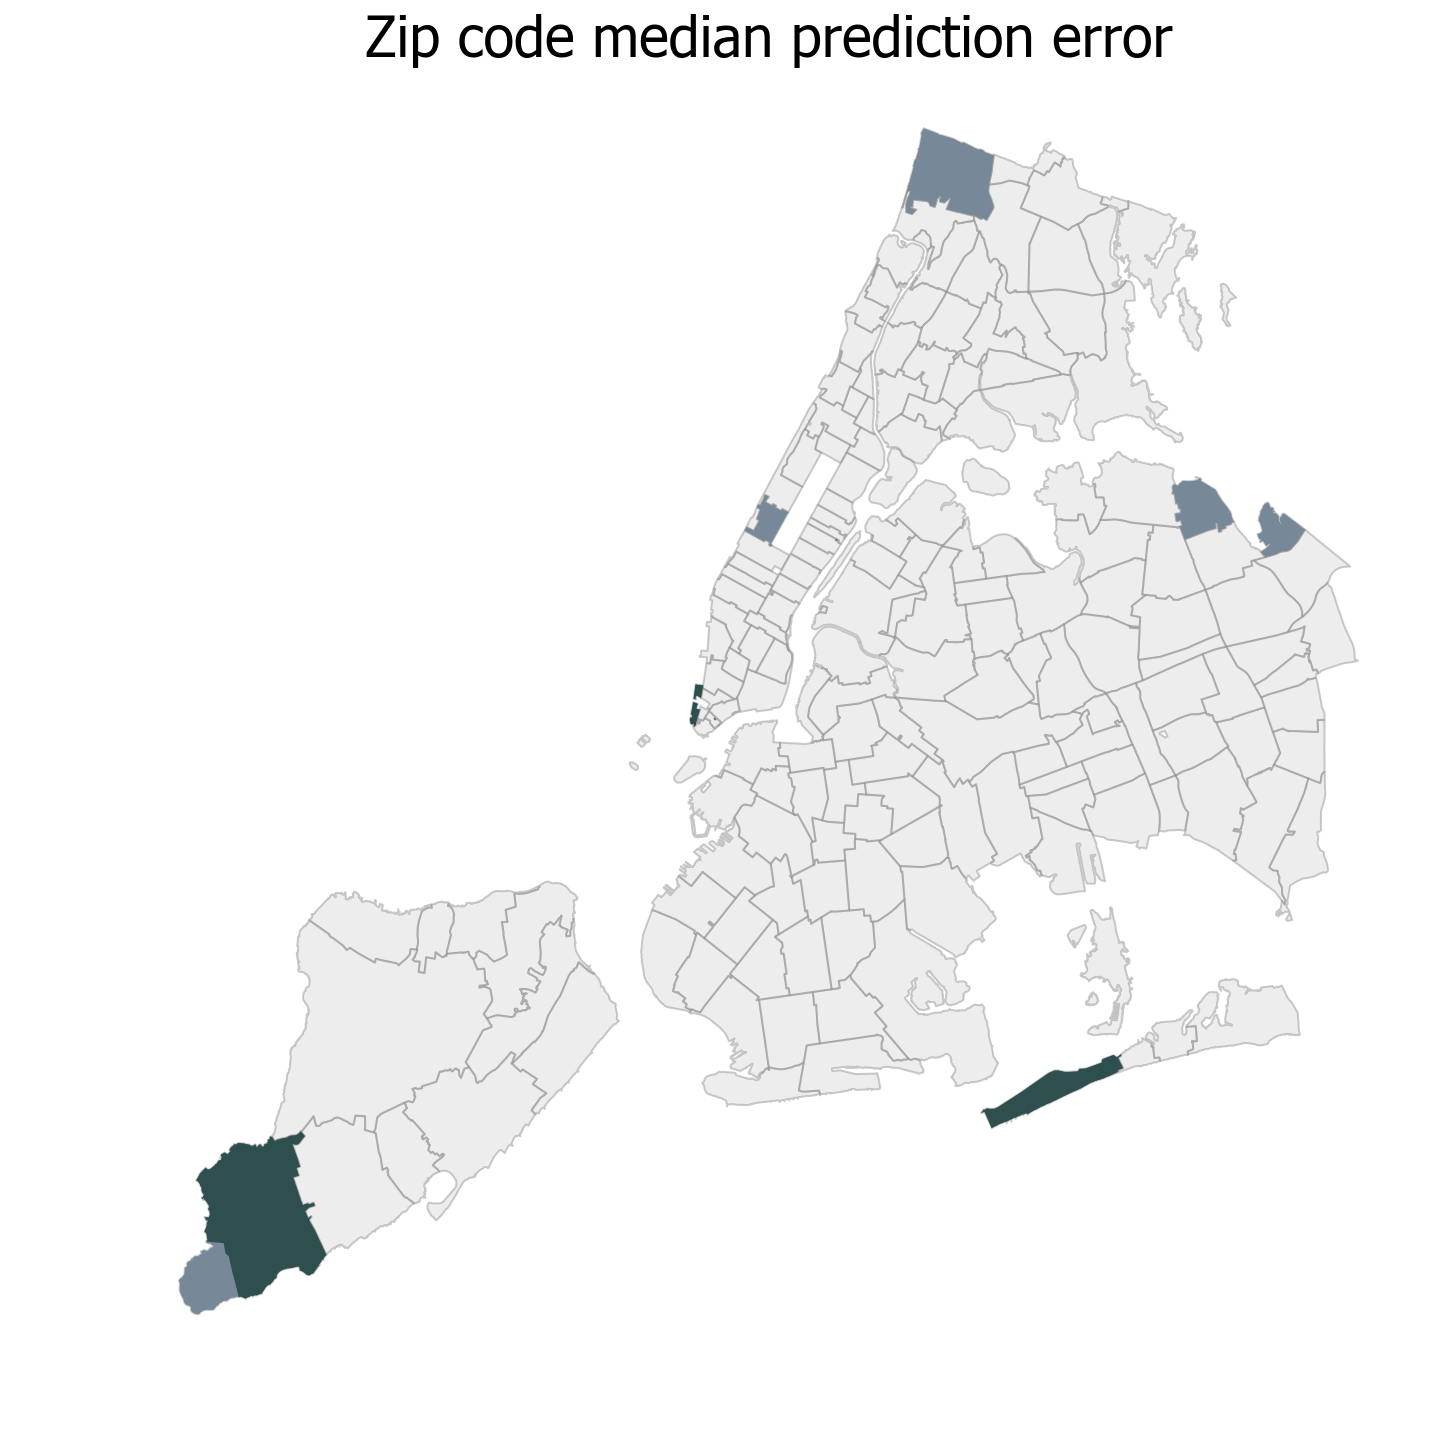

In [45]:
fig, ax = plt.subplots(figsize=(12,12))
zips.plot('medianErr', color='#D3D3D3', edgecolor='grey', alpha=0.4, ax=ax)
zips_more10.plot('medianErr', color='#778899', ax=ax)
zips_more20.plot('medianErr', color='#2F4F4F', ax=ax)
plt.axis('off')
plt.title('Zip code median prediction error', size=28)
plt.savefig(r'../output/spatial_error_map.png', bbox_inches="tight")
plt.show()

Finally, I aggregate the errors in zip code level and plot them. We see that only few zip codes show median errors more than 10 (gray) and 20$ (dark gray). Going back to the listing magnitude problem, we see that the underperforming zip codes are mainly in the least popular NYC areas, such as Staten Island, Far Rockaways and Riverdale.